### Домашнее задание 3
* Обучить AE собственной архитектуры на MNIST
* Обучить VAE собственной архитектуры на MNIST
* *Обучить VAE с переносом стиля на MNIST (на вход декодеру подавать hidden c таргетным значением, чтобы можно было нарисовать заданную цифру в заданном стиле)

## AE собственной архитектуры (из ДЗ2)

In [7]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [8]:
dataset = datasets.MNIST('.', download=True)

In [9]:
# hyperparams
in_chan = 1
hidden_ch = 64
out_ch = 1
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [10]:
class Encoder(nn.Module):
  #28x28 -> 14x14 -> 7x7
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.MaxPool2d(2, 2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7 x 7
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.pool1(self.conv1(x))))
    x = self.do2(self.activ(self.pool2(self.conv2(x))))
    x = self.conv3(x)

    return x

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=5, stride=1, padding=2)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.upsample1(self.conv1(x))))
    x = self.do2(self.activ(self.upsample2(self.conv2(x))))
    x = self.conv3(x)

    return x

class ConvAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = Encoder(in_chan, hidden_ch, out_ch)
    self.decoder = Decoder(in_chan, hidden_ch, out_ch)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_

In [11]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [12]:
model_conv = ConvAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.L1Loss()

epoch: 0, step: 0, loss: 0.16765087842941284
epoch: 0, step: 200, loss: 0.05996495485305786
epoch: 0, step: 400, loss: 0.05037703737616539


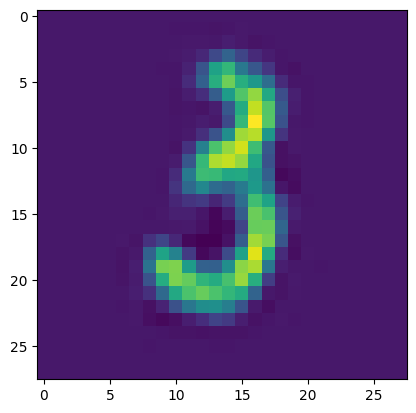

epoch: 1, step: 0, loss: 0.046568550169467926
epoch: 1, step: 200, loss: 0.04471932724118233
epoch: 1, step: 400, loss: 0.0432002991437912


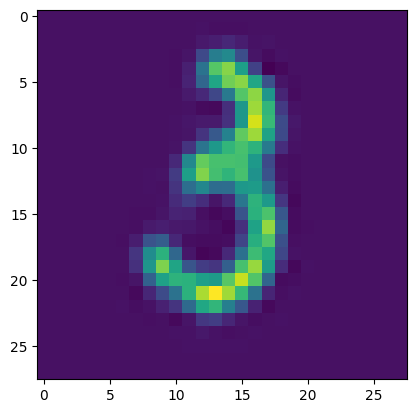

epoch: 2, step: 0, loss: 0.043887365609407425
epoch: 2, step: 200, loss: 0.04170225188136101
epoch: 2, step: 400, loss: 0.04154348373413086


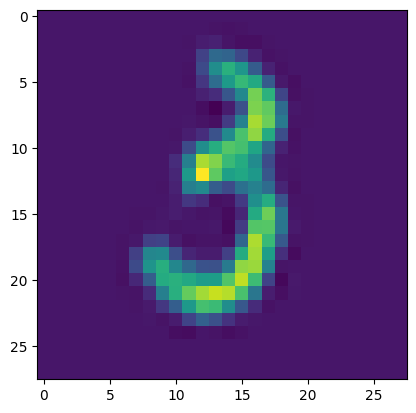

epoch: 3, step: 0, loss: 0.0419844351708889
epoch: 3, step: 200, loss: 0.039969202131032944


In [ ]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['data'].to(device))
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  plt.imshow(model_conv(item.to(device)).squeeze().cpu().detach().numpy())
  plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')